# Segmentation d'image avec 12 features

In [1]:
import os
import keras.models as models
#import keras.layers.containers as containers
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape,  Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
#os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['KERAS_BACKEND']="tensorflow"
# os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu0,floatX=float32,optimizer=fast_compile'


Using TensorFlow backend.


In [2]:
os.chdir("CamVid")
os.chdir("train")
train_images=os.listdir()
os.chdir("..")
os.chdir("trainannot")
train_targets = os.listdir()
os.chdir("..")
os.chdir("..")

In [3]:
X_train=[]
Y_train=[]
for path_image in train_images:
    img=plt.imread("./CamVid/train"+"/"+path_image)
    img=cv2.resize(img,(224,224))
    img = (img[:,:,0]+img[:,:,1]+img[:,:,2])/3
    img = np.expand_dims(img,axis=2)
    X_train.append(img)
    img=cv2.imread("./CamVid/trainannot"+"/"+path_image)
    img=cv2.resize(img,(224,224))
#     for i in range(img.shape[0]):
#         for j in range(img.shape[1]):
#             if 
    Y_train.append(np.expand_dims(np.concatenate(img[:,:,0]),axis=1))
    
#     img=cv2.resize(img,(224,224))
Y_train=np.array(Y_train)
X_train=np.array(X_train)
nb_class=np.max(Y_train)+1-np.min(Y_train)
print("Nombre de classe :",nb_class)
X_train.shape


Nombre de classe : 12


(367, 224, 224, 1)

In [29]:
epoch = 20
batch_size = 4
tf.reset_default_graph()

# Input features and output targets.
features  = tf.placeholder(tf.float32,shape=[None,224,224,1])
targets = tf.placeholder(tf.float32,shape=[None,224*224,1])
with tf.name_scope('Iterator'):
# Create separate Datasets for training and validation
    train_dataset = tf.data.Dataset.from_tensor_slices((features, targets))
    train_dataset = train_dataset.shuffle(buffer_size=2000).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((features, targets))
    val_dataset = val_dataset.batch(1)

# Iterator has to have same output types across all Datasets to be used
    iterator = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
    images, labels = iterator.get_next()
    
# Initialize with required Datasets
labels=tf.cast(labels,tf.int32)
train_iterator = iterator.make_initializer(train_dataset)
val_iterator = iterator.make_initializer(val_dataset)

with tf.name_scope('fc1_CNN'):
    fc1_conv = tf.layers.conv2d(images,filters=64, kernel_size=(5,5),padding='SAME')
    fc1_conv = tf.layers.conv2d(fc1_conv,filters=64, kernel_size=(5,5),padding='SAME')
    fc1_conv_norm = tf.layers.batch_normalization(fc1_conv, training=True)
    fc1_relu = tf.nn.relu(fc1_conv_norm)
    fc1_pool = tf.layers.max_pooling2d(inputs=fc1_relu, pool_size=(2,2), strides=(2,2))
    
with tf.name_scope('fc2_CNN'):
    fc2_conv = tf.layers.conv2d(fc1_pool,filters=128, kernel_size=(3,3),padding='SAME')
    fc2_conv = tf.layers.conv2d(fc2_conv,filters=128, kernel_size=(3,3),padding='SAME')
    fc2_conv_norm = tf.layers.batch_normalization(fc2_conv, training=True)
    fc2_relu = tf.nn.relu(fc2_conv_norm)
    fc2_pool = tf.layers.max_pooling2d(inputs=fc2_relu, pool_size=(2,2), strides=(2,2))
    
with tf.name_scope('fc3_CNN'):
    fc3_conv = tf.layers.conv2d(fc2_pool,filters=256, kernel_size=(3,3),padding='SAME')
    fc3_conv = tf.layers.conv2d(fc3_conv,filters=256, kernel_size=(3,3),padding='SAME')
    fc3_conv = tf.layers.conv2d(fc3_conv,filters=256, kernel_size=(3,3),padding='SAME')
    fc3_conv_norm = tf.layers.batch_normalization(fc3_conv, training=True)
    fc3_relu = tf.nn.relu(fc3_conv_norm)
    fc3_pool = tf.layers.max_pooling2d(inputs=fc3_relu, pool_size=(2,2), strides=(2,2))
    
with tf.name_scope('fc4_CNN'):
    fc4_conv = tf.layers.conv2d(fc3_pool,filters=512, kernel_size=(3,3),padding='SAME')
    fc4_conv = tf.layers.conv2d(fc4_conv,filters=512, kernel_size=(3,3),padding='SAME')
    fc4_conv = tf.layers.conv2d(fc4_conv,filters=512, kernel_size=(3,3),padding='SAME')
    fc4_conv_norm = tf.layers.batch_normalization(fc4_conv, training=True)
    fc4_relu = tf.nn.relu(fc4_conv_norm)
    fc4_pool = tf.layers.max_pooling2d(inputs=fc4_relu, pool_size=(2,2), strides=(2,2))
    
with tf.name_scope('fc5_CNN'):
    fc5_conv = tf.layers.conv2d(fc4_pool,filters=512, kernel_size=(3,3),padding='SAME')
    fc5_conv = tf.layers.conv2d(fc5_conv,filters=512, kernel_size=(3,3),padding='SAME')
    fc5_conv = tf.layers.conv2d(fc5_conv,filters=512, kernel_size=(3,3),padding='SAME')
    fc5_conv_norm = tf.layers.batch_normalization(fc5_conv, training=True)
    fc5_relu = tf.nn.relu(fc5_conv_norm)
    fc5_pool = tf.layers.max_pooling2d(inputs=fc5_relu, pool_size=(2,2), strides=(2,2))
    
with tf.name_scope('de1_CNN'):
    de1_ups=tf.image.resize_nearest_neighbor(fc5_pool, (2*7,2*7))
    de1_conv = tf.layers.conv2d(de1_ups,filters=512, kernel_size=(3,3),padding='SAME')
    de1_conv = tf.layers.conv2d(de1_conv,filters=512, kernel_size=(3,3),padding='SAME')
    de1_conv = tf.layers.conv2d(de1_conv,filters=512, kernel_size=(3,3),padding='SAME')
    de1_conv_norm = tf.layers.batch_normalization(de1_conv, training=True)
    de1_relu = tf.nn.relu(de1_conv_norm)
    
    
    
with tf.name_scope('de2_CNN'):
    de2_ups=tf.image.resize_nearest_neighbor(de1_relu, (2*14,2*14))
    de2_conv = tf.layers.conv2d(de1_ups,filters=256, kernel_size=(3,3),padding='SAME')
    de2_conv = tf.layers.conv2d(de2_conv,filters=256, kernel_size=(3,3),padding='SAME')
    de2_conv = tf.layers.conv2d(de2_conv,filters=256, kernel_size=(3,3),padding='SAME')
    de2_conv_norm = tf.layers.batch_normalization(de2_conv, training=True)
    de2_relu = tf.nn.relu(de2_conv_norm)
    
    
with tf.name_scope('de3_CNN'):
    de3_ups=tf.image.resize_nearest_neighbor(de2_relu, (2*28,2*28))
    de3_conv = tf.layers.conv2d(de3_ups,filters=128, kernel_size=(3,3),padding='SAME')
    de3_conv = tf.layers.conv2d(de3_conv,filters=128, kernel_size=(3,3),padding='SAME')
    de3_conv = tf.layers.conv2d(de3_conv,filters=128, kernel_size=(3,3),padding='SAME')
    de3_conv_norm = tf.layers.batch_normalization(de3_conv, training=True)
    de3_relu = tf.nn.relu(de3_conv_norm)

with tf.name_scope('de4_CNN'):
    de4_ups=tf.image.resize_nearest_neighbor(de3_relu, (2*56,2*56))
    de4_conv = tf.layers.conv2d(de4_ups,filters=64, kernel_size=(3,3),padding='SAME')
    de4_conv = tf.layers.conv2d(de4_conv,filters=64, kernel_size=(3,3),padding='SAME')
    de4_conv_norm = tf.layers.batch_normalization(de4_conv, training=True)
    de4_relu = tf.nn.relu(de4_conv_norm)

with tf.name_scope('de5_CNN'):
    de5_ups=tf.image.resize_nearest_neighbor(de4_relu, (2*112,2*112))
    de5_conv = tf.layers.conv2d(de5_ups,filters=nb_class, kernel_size=(3,3),padding='SAME')
    de5_conv = tf.layers.conv2d(de5_conv,filters=nb_class, kernel_size=(3,3),padding='SAME')
    de5_conv_norm = tf.layers.batch_normalization(de5_conv, training=True)

with tf.name_scope('reshape_CNN'):
    reshape_CNN=tf.reshape(de5_conv_norm,[-1,224*224,12])
    output = tf.nn.softmax(reshape_CNN)

In [30]:
with tf.name_scope('Loss_function'):
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=output)

with tf.name_scope('Optimizer'):
    learning_rate=tf.placeholder(tf.float32)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)

with tf.name_scope('Prediction'):
    true_label = tf.argmax(input=labels, axis=2)
    pred = tf.argmax(input=output, axis=2)  

In [33]:
import time
epoch=10
sess=tf.Session()
sess.run(tf.global_variables_initializer())
#Load weight
t0=time.time()
sess.run(train_iterator, feed_dict = {features: X_train, targets: Y_train })
print("Data load in iterator :",time.time()-t0)

for e in range(epoch):
    t0=time.time()
    sess.run([train_op],feed_dict={learning_rate:0.01})
    print("Epoch :",e," -- Time :",time.time()-t0)
    if (e%5==0):
        _,cost = sess.run([train_op,loss],feed_dict={learning_rate:0.01})
        print("Epoch :",e," -- Time :",time.time()-t0)
        print("Cost :",cost)

Data load in iterator : 0.06800389289855957
Epoch : 0  -- Time : 19.672125101089478
Epoch : 0  -- Time : 39.15823984146118
Cost : 2.4822288
Epoch : 1  -- Time : 19.061090230941772
Epoch : 2  -- Time : 18.917081832885742
Epoch : 3  -- Time : 19.009087324142456
Epoch : 4  -- Time : 18.97008514404297
Epoch : 5  -- Time : 19.205098390579224
Epoch : 5  -- Time : 38.4041965007782
Cost : 2.3895566
Epoch : 6  -- Time : 19.078091144561768
Epoch : 7  -- Time : 18.899080991744995
Epoch : 8  -- Time : 19.396109580993652
Epoch : 9  -- Time : 19.110093116760254


In [35]:
sess.run(train_iterator, feed_dict = {features: X_train, targets: Y_train })

for e in range(100):
    t0=time.time()
    sess.run([train_op],feed_dict={learning_rate:0.01})
    print("Epoch :",e," -- Time :",time.time()-t0)
    if (e%5==0):
        _,cost = sess.run([train_op,loss],feed_dict={learning_rate:0.01})
        print("Epoch :",e," -- Time :",time.time()-t0)
        print("Cost :",cost)

Epoch : 0  -- Time : 20.91619634628296
Epoch : 0  -- Time : 40.778332471847534
Cost : 2.0644944
Epoch : 1  -- Time : 20.859193086624146
Epoch : 2  -- Time : 19.419110774993896
Epoch : 3  -- Time : 20.24715805053711
Epoch : 4  -- Time : 21.412224769592285
Epoch : 5  -- Time : 22.98531460762024
Epoch : 5  -- Time : 45.798619508743286
Cost : 2.0745468
Epoch : 6  -- Time : 22.338277578353882
Epoch : 7  -- Time : 20.101149797439575
Epoch : 8  -- Time : 19.757129907608032
Epoch : 9  -- Time : 20.16515326499939
Epoch : 10  -- Time : 19.62012219429016
Epoch : 10  -- Time : 38.757216691970825
Cost : 2.0306807
Epoch : 11  -- Time : 19.64612364768982
Epoch : 12  -- Time : 20.820190906524658
Epoch : 13  -- Time : 20.597177982330322
Epoch : 14  -- Time : 20.298160791397095
Epoch : 15  -- Time : 20.9982008934021
Epoch : 15  -- Time : 41.714385747909546
Cost : 2.0035183
Epoch : 16  -- Time : 20.566176414489746
Epoch : 17  -- Time : 20.497172117233276
Epoch : 18  -- Time : 20.775188207626343
Epoch : 1

OutOfRangeError: End of sequence
	 [[Node: Iterator/IteratorGetNext = IteratorGetNext[output_shapes=[[?,224,224,1], [?,50176,1]], output_types=[DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Iterator/Iterator)]]

Caused by op 'Iterator/IteratorGetNext', defined at:
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelapp.py", line 499, in start
    self.io_loop.start()
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-2d177a19bd39>", line 18, in <module>
    images, labels = iterator.get_next()
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 410, in get_next
    name=name)), self._output_types,
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 2069, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\util\deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 3155, in create_op
    op_def=op_def)
  File "C:\Users\Thomas\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

OutOfRangeError (see above for traceback): End of sequence
	 [[Node: Iterator/IteratorGetNext = IteratorGetNext[output_shapes=[[?,224,224,1], [?,50176,1]], output_types=[DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](Iterator/Iterator)]]


In [11]:
t0=time.time()
z=sess.run(pred)
print("Time to calculate 1 iteration :",time.time()-t0)


Time to calculate 1 iteration : 1.783102035522461


In [22]:
type(z)

numpy.ndarray

In [24]:
z1=np.reshape(z[0],(224,224))

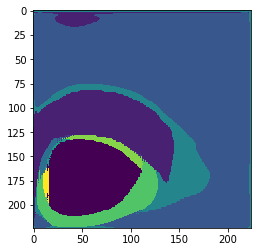

In [28]:
plt.imshow(z1)

In [ ]:
with tf.name_scope('de2_CNN'):
    de1_ups=tf.image.resize_nearest_neighbor(x, (2*H,2*W))

In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

#import pylab as pl
import matplotlib.cm as cm
import itertools
import numpy as np
#import theano as T

import tensorflow
import tensorflow as tf
#import theano.tensor as T
np.random.seed(1337) # for reproducibility
from keras.datasets import mnist
from keras.models import Sequential
#import keras.layers.containers as containers
from keras.layers.noise import GaussianNoise
import keras.models as models
#import keras.layers.containers as containers
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape,  Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils


from keras import backend as K

import cv2
import numpy as np

path = './CamVid/'
data_shape = 360*480

## Data Fetching 
I equalized histograms of rbg layers separately, so that change in lighting doesnt effect the results.

In [ ]:
def normalized(rgb):
    #return rgb/255.0
    norm=np.zeros((rgb.shape[0], rgb.shape[1], 3),np.float32)

    b=rgb[:,:,0]
    g=rgb[:,:,1]
    r=rgb[:,:,2]

    norm[:,:,0]=cv2.equalizeHist(b)
    norm[:,:,1]=cv2.equalizeHist(g)
    norm[:,:,2]=cv2.equalizeHist(r)

    return norm

def binarylab(labels):
    x = np.zeros([360,480,12])    
    for i in range(360):
        for j in range(480):
            x[i,j,labels[i][j]]=1
    return x

def prep_data():
    train_data = []
    train_label = []
    import os
    with open(path+'train.txt') as f:
        txt = f.readlines()
        txt = [line.split(' ') for line in txt]
    print(len(txt))
    for i in range(367):#len(txt)
        ## these paths are very specific to my machine
        train_data.append(normalized(cv2.imread(os.getcwd() + txt[i][0][7:])))#np.rollaxis(,2)
        train_label.append(binarylab(cv2.imread(os.getcwd() + txt[i][1][7:][:-1])[:,:,0]))
        print('.',end='')
    return np.array(train_data), np.array(train_label)

train_data, train_label = prep_data()

train_label = np.reshape(train_label,(367,data_shape,12))#367


### Creating and Compiling neuralnet

In [ ]:
np.array(Y_train).shape

In [ ]:
data_shape=360*480
def encoder():
        kernel = 3
        filter_size = 64
        pad = 1
        pool_size = 2
    
        E = Sequential()
        
        E.add(Layer(input_shape=(360, 480,1)))
        E.add(ZeroPadding2D(padding=(pad,pad)))
        
        E.add(Convolution2D(filter_size, (kernel, kernel), border_mode='valid'))
        E.add(BatchNormalization())
        E.add(Activation('relu'))
        E.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
        
        E.add(ZeroPadding2D(padding=(pad,pad)))
        E.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
        E.add(BatchNormalization())
        E.add(Activation('relu'))
        E.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
        
        E.add(ZeroPadding2D(padding=(pad,pad)))
        E.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
        E.add(BatchNormalization())
        E.add(Activation('relu'))
        E.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

        E.add(ZeroPadding2D(padding=(pad,pad)))
        E.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
        E.add(BatchNormalization())
        
        E.add(Activation('relu'))
        #E.summary()

        return E
    
def decoder():
    
        kernel = 3
        filter_size = 64
        pad = 1
        pool_size = 2
        
        D = Sequential()
        
        D.add(ZeroPadding2D(padding=(pad,pad)))
        D.add(Convolution2D(512, kernel, kernel, border_mode='valid'))
        D.add(BatchNormalization())

        #D.add(UnPooling2D(poolsize=(pool_size,pool_size)))
        D.add(UpSampling2D())
        
        D.add(ZeroPadding2D(padding=(pad,pad)))
        D.add(Convolution2D(256, kernel, kernel, border_mode='valid'))
        D.add(BatchNormalization())

        #D.add(UnPooling2D(poolsize=(pool_size,pool_size)))
        D.add(UpSampling2D())
        D.add(ZeroPadding2D(padding=(pad,pad)))
        D.add(Convolution2D(128, kernel, kernel, border_mode='valid'))
        D.add(BatchNormalization())

        #D.add(UnPooling2D(poolsize=(pool_size,pool_size)))
        D.add(UpSampling2D())
        D.add(ZeroPadding2D(padding=(pad,pad)))
        D.add(Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
        D.add(BatchNormalization())
        #D.summary()
    
        return D
    
def reshapeData() :
    dataReshape = Sequential()
    dataReshape.add(Convolution2D(12, 1, 1, border_mode='valid',))
    dataReshape.add(Reshape((12,data_shape)))
    dataReshape.add(Permute((2, 1)))
    dataReshape.add(Activation('softmax'))
    return dataReshape
    
model = Sequential()
model.add(encoder())
model.add(decoder())
model.add(reshapeData())
model.summary()
#model.compile(loss="categorical_crossentropy", optimizer='adadelta')
model.compile(loss='sparse_categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy'])

nb_epoch = 5
batch_size = 16

history = model.fit(np.array(X_train), np.array(Y_train), batch_size=batch_size, nb_epoch=nb_epoch, verbose=1 )



In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot((history.history['loss']))
plt.plot((history.history['val_loss']))
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot((history.history['loss']))
plt.plot((history.history['val_loss']))
plt.title('Model loss from 500 to 2000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.xlim((500, 2000))
plt.ylim((50000, 160000))
plt.show()